In [2]:
import numpy as np
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from pypika import Query, Table, Field, Schema, functions as fn
from dotenv import dotenv_values

In [3]:
# Load the environment variables from the .env file
env_vars = dotenv_values('.env')

# Get the password from the environment variables
password = env_vars.get('PASSWORD')

# Get user from the environment variables
user = env_vars.get('USER')


In [3]:
if password:
    print("Password retrieved successfully")
else:
    print("Password not found in .env file.")

Password retrieved successfully


In [4]:
db = mysql.connector.connect(host="localhost",
                             user="ramsus",
                             passwd=password,
                             database="pagos")


In [5]:
table = Table('pagos')

In [6]:
# Query to pandas dataframe for the sales per day
query = "SELECT DATE_FORMAT(fecha, '%W %M %d') AS dia, SUM(valor) AS total FROM pagos GROUP BY dia, fecha ORDER BY DATE(fecha)"
df = pd.read_sql(query, con=db)

/tmp/ipykernel_11044/1355553173.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=db)


In [7]:
df

,dia,total
0,Thursday June 08,2065000.0
1,Friday June 09,3240000.0
2,Tuesday June 13,1570000.0
3,Thursday June 15,1615000.0
4,Monday June 19,830000.0
5,Wednesday June 21,100000.0
6,Thursday June 22,800000.0
7,Friday June 23,1260000.0
8,Sunday June 25,815000.0
9,Monday June 26,370000.0


In [8]:
# Create dictionaries for month and day replacements
month_replacements = {
    'June': 'Junio',
    'July': 'Julio'
}

day_replacements = {
    'Sunday': 'Domingo',
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado'
}

In [9]:
# Replace month names and day names using dictionaries
df['dia'] = df['dia'].replace(month_replacements, regex=True)
df['dia'] = df['dia'].replace(day_replacements, regex=True)

# Now change the order as day_name day_number month_name

df['dia'] = df['dia'].str.split(' ').apply(lambda x: ' '.join([x[0], x[2], x[1]]))


df

,dia,total
0,Jueves 08 Junio,2065000.0
1,Viernes 09 Junio,3240000.0
2,Martes 13 Junio,1570000.0
3,Jueves 15 Junio,1615000.0
4,Lunes 19 Junio,830000.0
5,Miércoles 21 Junio,100000.0
6,Jueves 22 Junio,800000.0
7,Viernes 23 Junio,1260000.0
8,Domingo 25 Junio,815000.0
9,Lunes 26 Junio,370000.0


In [10]:
sns.set( palette="husl", color_codes=True, font_scale=1.5)
sns.set_context("paper", font_scale=1.5)
sns.set(rc={'figure.figsize':(11.7,8.27)})

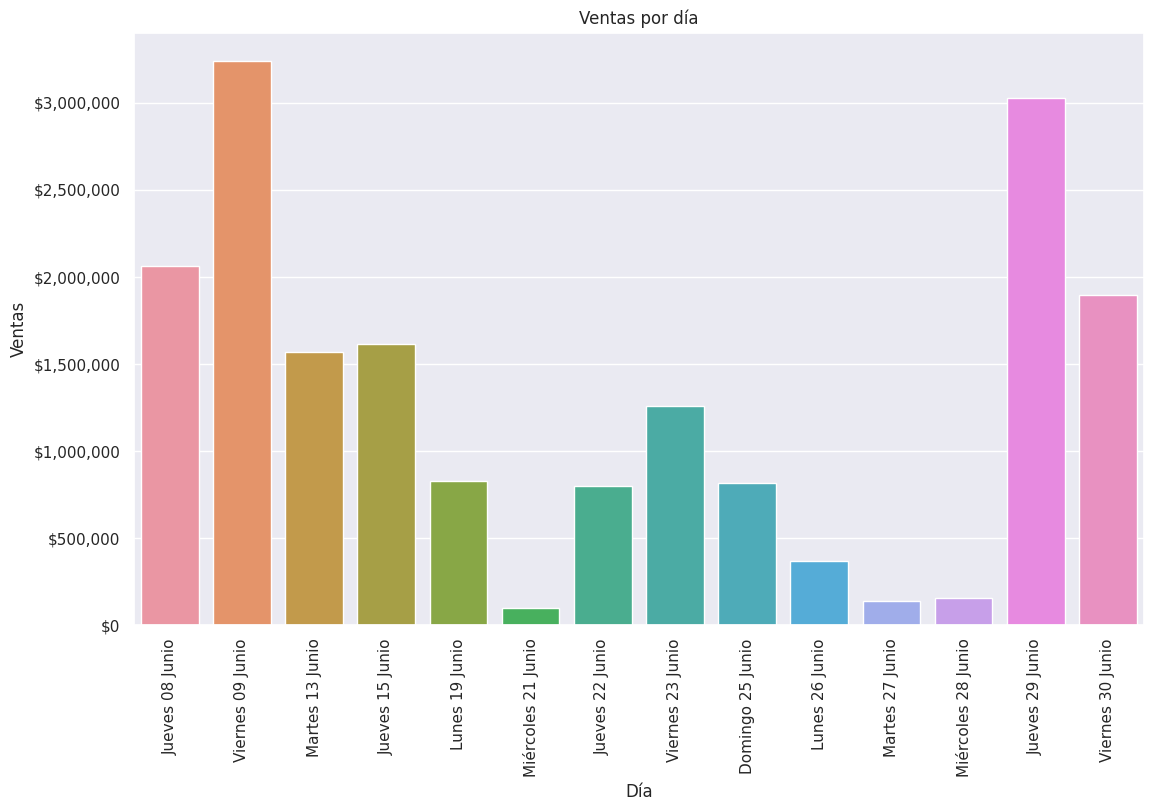

In [11]:
sns.barplot(x='dia', y='total', data=df, errorbar=None)
plt.title('Ventas por día')
plt.xlabel('Día')
plt.ylabel('Ventas')
plt.xticks(rotation=90)
# set scale name as "million"
plt.ticklabel_format(style='plain', axis='y')
# Format y axis as money
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
plt.tight_layout()
plt.savefig('ventas_por_dia.svg', format='svg', dpi=600)
plt.show()


In [9]:
# mean sales per weekday
query = "SELECT DAYNAME(dia) AS weekday, AVG(sales) AS mean_sales FROM ( SELECT DATE(fecha) AS dia, SUM(valor) AS sales FROM pagos GROUP BY dia, fecha ORDER BY DATE(fecha) ) AS sales GROUP BY weekday ORDER BY FIELD(weekday, 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')"
df = pd.read_sql(query, con=db)
df


/tmp/ipykernel_62623/2093718376.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=db)


,weekday,mean_sales
0,Monday,8.150000e+05
1,Tuesday,6.000000e+05
2,Wednesday,6.000000e+05
3,Thursday,1.650000e+05
4,Friday,1.877500e+06
5,Saturday,2.131667e+06


In [10]:
# change weekday names
df['weekday'] = df['weekday'].replace(day_replacements, regex=True)
df

,weekday,mean_sales
0,Lunes,8.150000e+05
1,Martes,6.000000e+05
2,Miércoles,6.000000e+05
3,Jueves,1.650000e+05
4,Viernes,1.877500e+06
5,Sábado,2.131667e+06


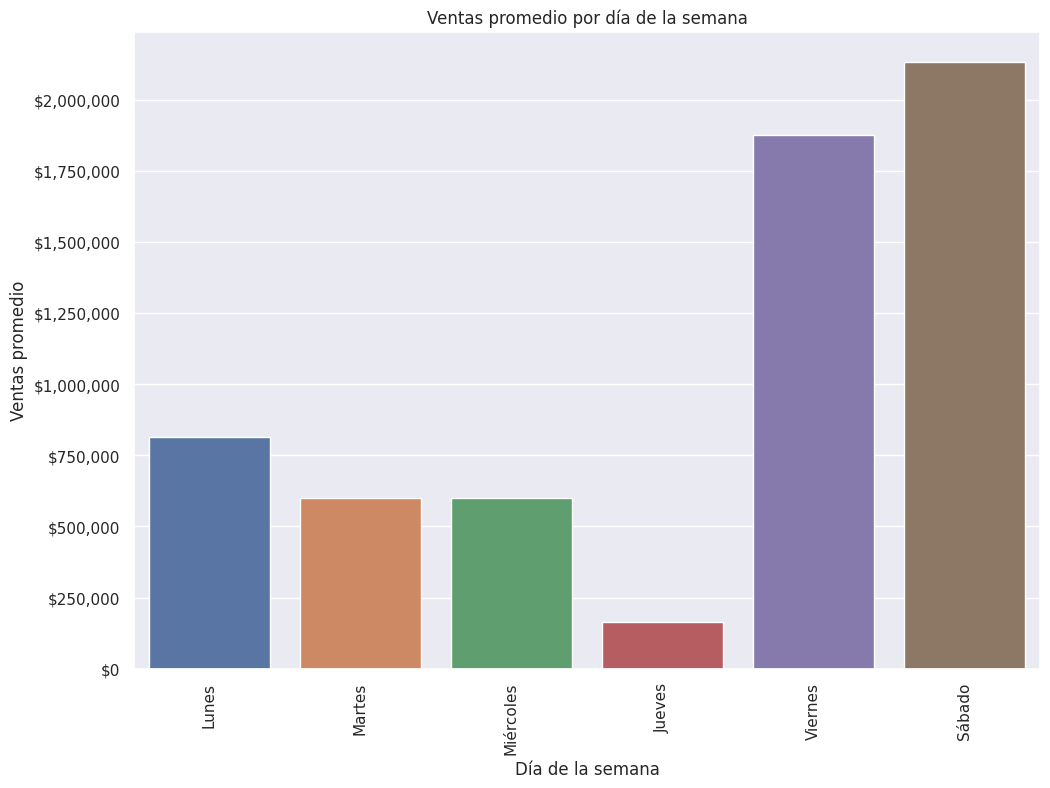

In [11]:
#bar plot
sns.barplot(x='weekday', y='mean_sales', data=df, errorbar=None)
plt.title('Ventas promedio por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Ventas promedio')
plt.xticks(rotation=90)
# set scale name as "millions"
plt.ticklabel_format(style='plain', axis='y')
# Format y axis as money
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
plt.savefig('ventas_promedio_por_dia.svg', format='svg', dpi=600)
plt.show()

In [12]:
query = "SELECT actividad, SUM(valor) AS total FROM pagos GROUP BY actividad ORDER BY total DESC"
df = pd.read_sql(query, con=db)

/tmp/ipykernel_62623/3979942014.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=db)


In [13]:
# add activity_1, activity_2 and activity_3 columns to dataframe 
df['activity_1'] = df['actividad'].str.split(',').str[0]
df['activity_2'] = df['actividad'].str.split(',').str[1]
df['activity_3'] = df['actividad'].str.split(',').str[2]

In [14]:
# Función para normalizar una actividad
def normalizar_actividad(actividad):
    if actividad is np.nan:
        return actividad
    else:
        actividad = actividad.lower()
        actividad = actividad.replace("controles", "control")
        actividad = actividad.replace("reparaciones", "reparacion")
        actividad = actividad.replace("extracciones", "extraccion")
        return actividad

# Aplicar la función de normalización a la columna 'activity_1' y 'activity_2' si existe
df['activity_1'] = df['activity_1'].apply(normalizar_actividad)
df['activity_2'] = df['activity_2'].apply(normalizar_actividad)


In [15]:
# Lista de categorías principales
categorias_principales = ['lipopapada', 'control', 'bichectomia', 'protesis', 'retenedores', 'resinas', 'papada', 'montaje', 'braquets', 'extraccion']

# Función para realizar los cambios en las actividades
def modificar_actividades(row):
    # Verificar si alguna de las actividades está en las categorías principales
    if row['activity_2'] in categorias_principales:
        # Mover la actividad a activity_1 y actualizar el valor que estaba en activity_1
        row['activity_1'], row['activity_2'] = row['activity_2'], row['activity_1']
    elif row['activity_3'] in categorias_principales:
        # Mover la actividad a activity_1 y actualizar el valor que estaba en activity_1
        row['activity_1'], row['activity_3'] = row['activity_3'], row['activity_1']
    
    return row

# Aplicar la función a cada fila del DataFrame
df = df.apply(modificar_actividades, axis=1)


In [16]:
# drop "90: deuda" and "pago porcentaje" rows
df = df.drop(df[df['activity_1'] == '90: deuda'].index)
df = df.drop(df[df['activity_1'] == 'pago porcentaje'].index)

In [17]:
# upload dataframe to database
# create new table
mycursor = db.cursor()
# execute only if table does not exist
mycursor.execute("SHOW TABLES LIKE 'actividades'")
result = mycursor.fetchone()
if result is None:
    print("Table does not exist")
    mycursor.execute("CREATE TABLE IF NOT EXISTS actividades (actividad VARCHAR(100), total INT(11))")
    # insert dataframe into table
    for index, row in df.iterrows():
        mycursor.execute("INSERT INTO actividades (actividad, total) VALUES (%s, %s)", (row['activity_1'], row['total']))
    db.commit()

In [18]:
def print_sql(query):
    mycursor.execute(query)
    result = mycursor.fetchall()
    for x in result:
        print(x)

In [19]:
# mean sales per activity
query = "SELECT actividad, AVG(total) AS mean_sales FROM actividades GROUP BY actividad ORDER BY mean_sales DESC"
A1 = pd.read_sql(query, con=db)

/tmp/ipykernel_62623/1136557628.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  A1 = pd.read_sql(query, con=db)


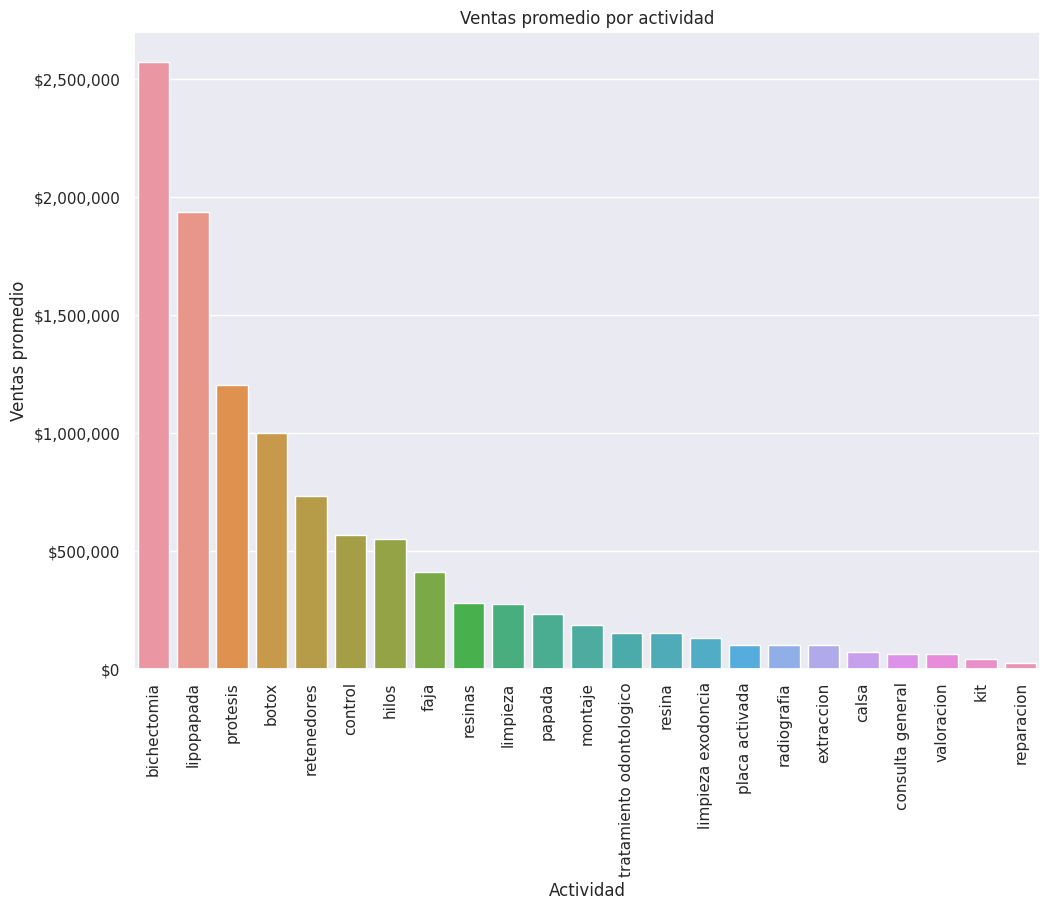

In [20]:
sns.barplot(x='actividad', y='mean_sales', data=A1, errorbar=None)
plt.title('Ventas promedio por actividad')
plt.xlabel('Actividad')

plt.ylabel('Ventas promedio')
plt.xticks(rotation=90)
# set scale name as "millions"
plt.ticklabel_format(style='plain', axis='y')
# Format y axis as money
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
plt.show()

In [21]:
# query to get the total sales per activity
query = "SELECT actividad, SUM(total) AS total FROM actividades GROUP BY actividad ORDER BY total DESC"

# save query result to dataframe
A1 = pd.read_sql(query, con=db)

/tmp/ipykernel_62623/2194308576.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  A1 = pd.read_sql(query, con=db)


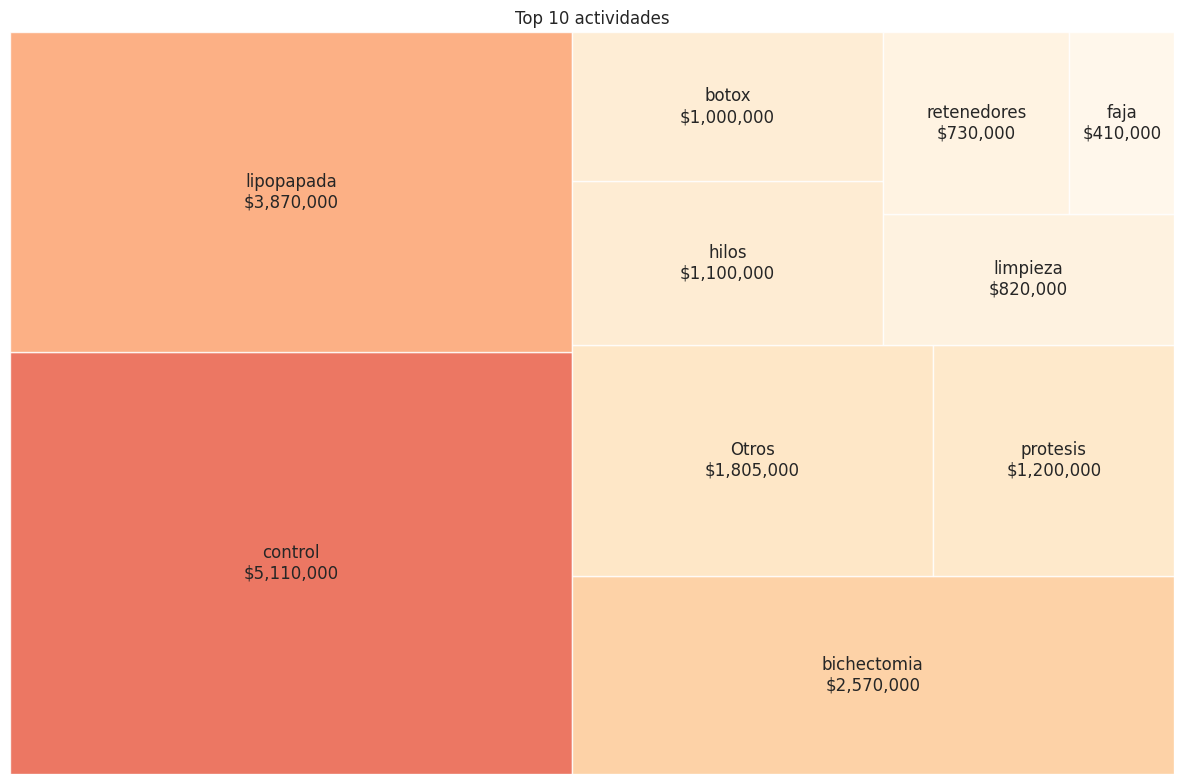

In [22]:
# make a treemap of top 10 activities and save the others in 'others' category
A1['total'] = A1['total'].astype(float)

# save total of all activities
total = A1['total'].sum()

# Get top 9 activities
A1 = A1.head(9)

# add others category
others = pd.DataFrame([['Otros', total - A1['total'].sum()]], columns=['actividad', 'total'])
A1 = pd.concat([A1, others])

# sort values by total
A1 = A1.sort_values(by='total', ascending=False)

# create a color palette, mapped to these values 
cmap = plt.cm.OrRd
mini=min(A1['total'])
maxi=max(A1['total'])
norm = plt.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in df['total']]

# create labels inside the plot (total formatted as money)
labels = [str(i) + '\n' + str(j) for i, j in zip(A1['actividad'], A1['total'].map('${:,.0f}'.format))]
# create plot
plt.figure(figsize=(12,8))
squarify.plot(sizes=A1['total'], label=labels, alpha=.8, color=colors)
plt.title('Top 10 actividades')
# add note with others value
plt.axis('off')
plt.tight_layout()
plt.savefig('top_10_actividades.svg', format='svg', dpi=600)
plt.show()


In [23]:
A1

,actividad,total
0,control,5110000.0
1,lipopapada,3870000.0
2,bichectomia,2570000.0
0,Otros,1805000.0
3,protesis,1200000.0
4,hilos,1100000.0
5,botox,1000000.0
6,limpieza,820000.0
7,retenedores,730000.0
8,faja,410000.0


In [ ]:
# conda env export > environment.yml